In [ ]:
#import libraries

!pip install --upgrade --no-deps gensim==4.3.3 emoji==2.14.1


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import emoji
import os
from google.colab import files


In [ ]:
filename = '/content/sentiment_analysis.csv'
df = pd.read_csv(filename)
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 25 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   CustomerID             100000 non-null  object 
 1   Name                   100000 non-null  object 
 2   Age                    100000 non-null  int64  
 3   Gender                 100000 non-null  object 
 4   Geography              100000 non-null  object 
 5   Native_Place           100000 non-null  object 
 6   Marital_Status         100000 non-null  object 
 7   Tenure                 100000 non-null  int64  
 8   Account_Type           100000 non-null  object 
 9   Balance                100000 non-null  float64
 10  NumOfProducts          100000 non-null  int64  
 11  HasCrCard              100000 non-null  int64  
 12  IsActiveMember         100000 non-null  int64  
 13  EstimatedSalary        100000 non-null  float64
 14  Monthly_Income         100000 non-nul

,CustomerID,Name,Age,Gender,Geography,Native_Place,Marital_Status,Tenure,Account_Type,Balance,...,CreditScore,Loan_Status,EMI_Amount,Exited,Branch_Code,Account_Open_Date,Last_Transaction_Date,Customer_Review,Review_Sentiment,Sentiment_Score
0,CID000001,Sunita Sharma,21,Other,Tamil Nadu,Hyderabad,Married,4,Current,676699.50,...,523,Auto,4238.57,0,BR072,2024-03-10,2024-06-23,Reasonable fees 💲,Neutral,0.733885
1,CID000002,Amit Kumar,53,Male,Karnataka,Pune,Divorced,8,Premium,215313.77,...,667,Business,30226.31,0,BR094,2020-02-26,2024-08-20,Professional staff 🌟,Positive,0.910818
2,CID000003,Rohan Gupta,55,Other,West Bengal,Lucknow,Married,2,Savings,661263.30,...,689,Education,43308.58,0,BR021,2024-04-07,2024-11-21,Great mobile app 🥰,Positive,0.983285
3,CID000004,Sunita Iyer,27,Other,Karnataka,Jaipur,Married,5,NRI,379455.44,...,332,Business,19905.26,0,BR028,2022-02-15,2024-12-11,Professional staff 🌟,Positive,0.910818
4,CID000005,Priya Iyer,76,Male,Tamil Nadu,Bangalore,Married,17,Senior Citizen,747013.80,...,441,Multiple,27711.22,0,BR015,2021-11-16,2024-07-04,Professional staff 🌟,Positive,0.910818


In [ ]:
#check for no missing values in columns
df.isnull().sum()


,0
CustomerID,0
Name,0
Age,0
Gender,0
Geography,0
Native_Place,0
Marital_Status,0
Tenure,0
Account_Type,0
Balance,0


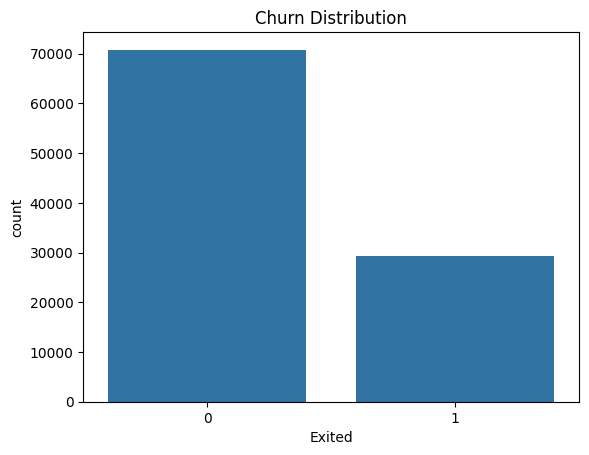

In [ ]:
# 1 = churned, 0 = retained
sns.countplot(data=df, x='Exited')
plt.title("Churn Distribution")
plt.show()


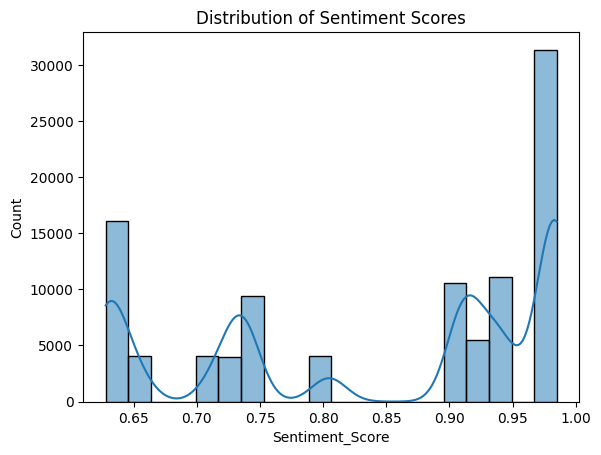

In [ ]:
#postive sentiments more towards 1 in 0-1 range
sns.histplot(df['Sentiment_Score'], bins=20, kde=True)
plt.title("Distribution of Sentiment Scores")
plt.show()


In [ ]:

print(df.columns.tolist())

['CustomerID', 'Name', 'Age', 'Gender', 'Geography', 'Native_Place', 'Marital_Status', 'Tenure', 'Account_Type', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Monthly_Income', 'CreditScore', 'Loan_Status', 'EMI_Amount', 'Exited', 'Branch_Code', 'Account_Open_Date', 'Last_Transaction_Date', 'Customer_Review', 'Review_Sentiment', 'Sentiment_Score']


In [ ]:
#feature engineering
df.drop(['CustomerID', 'Name', 'Account_Open_Date', 'Last_Transaction_Date'], axis=1, inplace=True)


In [ ]:
#check if dropped
print(df.columns.tolist())


['Age', 'Gender', 'Geography', 'Native_Place', 'Marital_Status', 'Tenure', 'Account_Type', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Monthly_Income', 'CreditScore', 'Loan_Status', 'EMI_Amount', 'Exited', 'Branch_Code', 'Customer_Review', 'Review_Sentiment', 'Sentiment_Score']


In [ ]:
# Categorical columns  TF-IDF ,except 'Customer_Review'
cat_cols = ['Gender', 'Geography', 'Native_Place', 'Marital_Status', 'Account_Type', 'Loan_Status', 'Branch_Code', 'Review_Sentiment']
df[cat_cols] = df[cat_cols].astype(str)

# Combine all categorical columns
df['combined_cats'] = df[cat_cols].agg(' '.join, axis=1)

# Apply TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=500)
cat_tfidf = tfidf.fit_transform(df['combined_cats'])

# Convert sparse matrix to DataFrame
cat_tfidf_df = pd.DataFrame(cat_tfidf.toarray(), columns=tfidf.get_feature_names_out())

# Make sure the index aligns with df
cat_tfidf_df.index = df.index

# Drop original categorical columns and combined text
df.drop(cat_cols + ['combined_cats'], axis=1, inplace=True)

# Numeric columns to scale
cols_to_scale = ['Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'Monthly_Income', 'CreditScore', 'EMI_Amount', 'Sentiment_Score']

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

# Final DataFrame by concatenating scaled numeric and TF-IDF features
df_final = pd.concat([df, cat_tfidf_df], axis=1)

print("Final dataframe shape:", df_final.shape)
print(df_final.head())


Final dataframe shape: (100000, 160)
        Age    Tenure   Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0 -1.553360 -0.989785  0.614248      -1.344123          1               0   
1  0.073560 -0.328088 -0.982476       0.443584          0               0   
2  0.175242 -1.320633  0.560827       0.443584          0               0   
3 -1.248313 -0.824360 -0.414429      -0.450270          1               0   
4  1.242908  1.160731  0.857585       1.337437          1               1   

   EstimatedSalary  Monthly_Income  CreditScore  EMI_Amount  ...  salary  \
0        -1.635106       -1.635106    -0.440697   -1.030932  ...     0.0   
1        -0.419883       -0.419883     0.386820    0.173194  ...     0.0   
2         1.268846        1.268846     0.513246    0.779353  ...     0.0   
3        -0.943551       -0.943550    -1.538307   -0.305026  ...     0.0   
4        -0.977312       -0.977312    -0.911922    0.056659  ...     0.0   

    savings    senior  single  student     

In [ ]:
#x:input y:target/output
y = df['Exited']
X = df.drop('Exited', axis=1)



In [ ]:
from sklearn.model_selection import train_test_split

# 80 training 20 testing
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42, stratify=y)


In [ ]:
# Drop raw review text after extracting sentiment score
X_train = X_train.drop(columns=['Customer_Review'])
X_test = X_test.drop(columns=['Customer_Review'])


In [ ]:
#train using xgboost
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

In [ ]:
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train, y_train)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:23:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [ ]:
y_pred = xgb_model.predict(X_test)


 Training Accuracy: 0.9077
Testing Accuracy:  0.9031


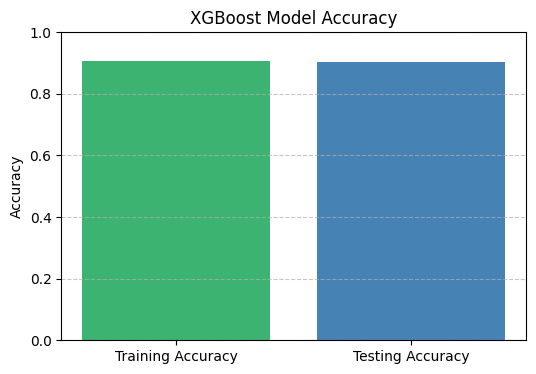

In [ ]:
train_acc = accuracy_score(y_train, xgb_model.predict(X_train))
test_acc = accuracy_score(y_test, y_pred)

print(f" Training Accuracy: {train_acc:.4f}")
print(f"Testing Accuracy:  {test_acc:.4f}")
# Plot results
plt.figure(figsize=(6, 4))
plt.bar(['Training Accuracy', 'Testing Accuracy'], [train_acc, test_acc], color=['mediumseagreen', 'steelblue'])
plt.ylim(0, 1)
plt.title('XGBoost Model Accuracy')
plt.ylabel('Accuracy')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [ ]:

import joblib

model_filename = "xgb_churn_model.pkl"
joblib.dump(xgb_model, model_filename)
print("Model Saved Successfully")
from google.colab import files

files.download(model_filename)



Model Saved Successfully


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:

scaler_filename = "scaler.pkl"
joblib.dump(scaler, scaler_filename)
files.download(scaler_filename)

tfidf_filename = "tfidf_vectorizer.pkl"
joblib.dump(tfidf, tfidf_filename)
files.download(tfidf_filename)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#prediction of first 5 customers
model = joblib.load("xgb_churn_model.pkl")  # load the model object from file
sample_input = X_test.iloc[0:5]
prediction = model.predict(sample_input)   # call predict on the model object
print("Prediction:", prediction)


Prediction: [1 1 0 1 1]


In [ ]:
for i in range(5):
    true_label = y_test.iloc[i]
    print(f"Customer {i+1}:")
    print("Prediction:", prediction[i])
    print("True Label:", true_label)
    if prediction[i] == true_label:
        print("Correct prediction\n")
    else:
        print("Incorrect prediction\n")


Customer 1:
Prediction: 1
True Label: 1
Correct prediction

Customer 2:
Prediction: 1
True Label: 1
Correct prediction

Customer 3:
Prediction: 0
True Label: 0
Correct prediction

Customer 4:
Prediction: 1
True Label: 1
Correct prediction

Customer 5:
Prediction: 1
True Label: 1
Correct prediction



In [ ]:
y_pred_all = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_all)
print(f"Test Accuracy on full test set: {test_accuracy:.4f}")

Test Accuracy on full test set: 0.9031
